In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os,cmocean
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import cmocean.cm as cm
import matplotlib.gridspec as gridspec

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
cascadiafile = '/home/ssahu/saurav/NEMO_run/bathy_casacadia/cascadia.bil'
def getcascadia(filename):
    # Adapted from: https://pymorton.wordpress.com/2016/02/26/plotting-prism-bil-arrays-without-using-gdal/
    def read_prism_hdr(hdr_path):
        """Read an ESRI BIL HDR file"""
        with open(hdr_path, 'r') as input_f:
            header_list = input_f.readlines()
        return dict(item.strip().split() for item in header_list)
    def read_prism_bil(bil_path):
        """Read an array from ESRI BIL raster file"""
        hdr_dict = read_prism_hdr(bil_path.replace('.bil', '.hdr'))
        data = np.fromfile(bil_path, dtype=np.int16).byteswap()
        data = data.reshape(int(hdr_dict['NROWS']), int(hdr_dict['NCOLS']))
        return data
    z = np.flipud(read_prism_bil(filename))    # load data
    mask = (z == 0) | (z >= 10000)             # mask for nonexistant points and land points
    z -= 10000                                 # remove offset
    z *= -1                                    # make depths positive
    z[mask] = 0                                # set masked values to zero
    zm = ma.masked_array(z, mask=mask)
    # Construct Cascadia coordinates
    xmin, xmax, dx = -738044.062, 749705.938, 250
    ymin, ymax, dy = 101590.289, 1710340.289, 250
    x=xmin + dx*np.arange(0, z.shape[1]) + dx/2
    y=ymin + dy*np.arange(0, z.shape[0]) + dy/2
    p = Proj(r'+proj=lcc +lat_1=41.5 +lat_2=50.5 +lat_0=38 +lon_0=-124.5 +x_0=0 +y_0=0 +ellps=clrk66 +no_defs')
    lat_min, lat_max=47, 50
    lon_min, lon_max=123, 130
    lat=np.linspace(lat_min,lat_max,660)
    lon=np.linspace(lon_min,lon_max,1144)
    grid=np.meshgrid(lat,lon)
    return x,y,z,p

In [3]:
x,y,z,p = getcascadia(cascadiafile)

print (np.amax(x))
print (x)

749580.938
[-737919.062 -737669.062 -737419.062 ...,  749080.938  749330.938
  749580.938]


<IPython.core.display.Javascript object>


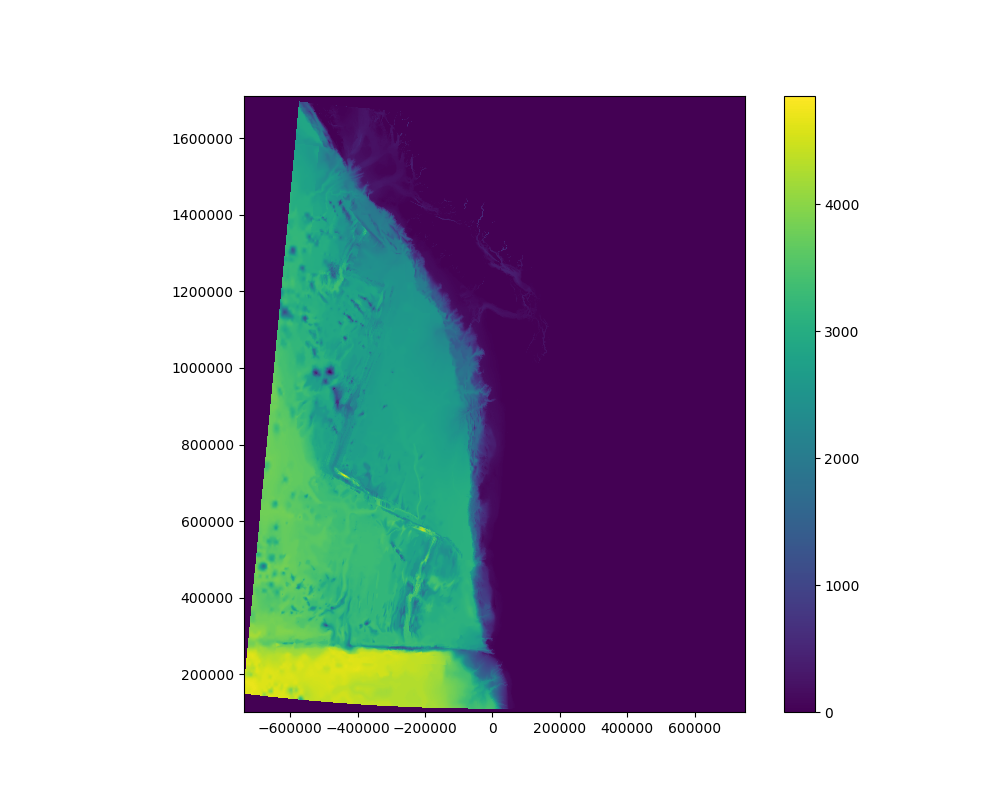

In [4]:
x,y,z,p = getcascadia(cascadiafile)
#plt.figure()
#plt.pcolormesh(x,y,z)
#plt.colorbar(z)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(x,y,z)
fig.colorbar(mesh)

In [5]:
np.nonzero(z),np.shape(z)

((array([  40,   40,   40, ..., 6382, 6382, 6382]),
  array([2786, 2787, 2788, ...,  666,  667,  668])),
 (6435, 5951))

def create_grid_file(nx, ny,thelons, thelats, filename):
    ''' This function saves the coordinates for all
    points in the defined grid. This grid will then 
    be processed to calculate the scaling factors
    required by NEMO.
    
    :arg filename: Directory and name of netCDF4 file
    '''
    
    directory = '/home/ssahu/saurav/NEMO_run/bathy_casacadia/'
    dataset = Dataset(directory + filename, 'w')
    x = dataset.createDimension('x', nx)
    y = dataset.createDimension('y', ny)

    lons = dataset.createVariable('grid_lons', 'f8', ('x'))
    lats = dataset.createVariable('grid_lats', 'f8', ('y'))


    lons.standard_name = 'Longitude'
    lats.standard_name = 'Latitude'
    lons.units = 'degrees east'
    lons.units = 'degrees north'

    lons[:] = thelons[:]
    lats[:] = thelats[:]

    dataset.close()

#specify the grid points along longitude (x_axis)
Nx= 250
lon= np.linspace(-130, -123.0, num=Nx)

#specify the grid points along latitude (y_axis)
Ny= 132
lat= np.linspace(47.0, 50.0, num=Ny)
create_grid_file(Nx, Ny, lon, lat, 'basic_grid_attempt_practise.nc')

lon = mat_contents['grid_lons']
Nx  = len(lon) #sea_grid cell size (+1) along x
lat = mat_contents['grid_lats']
Ny  = len(lat) #sea_grid cell size (+1) along y
create_grid_file(Nx, Ny, lon, lat, 'basic_grid_seagridv2_practise.nc')
Nx

In [23]:
#Load the ouput file of JP together with all the scaling factors

coord = nc.Dataset('coordinates_westcoast_seagrid_high_resolution_truncated.nc')
nc_tools.show_variables(coord)

T_grid_lon = coord.variables['glamt'][0,:]
T_grid_lat = coord.variables['gphit'][0,:]

e1t = coord.variables['e1t'][:,:]
e2t = coord.variables['e2t'][:,:]
print(np.min(e1t),np.max(e1t))
print(np.min(e2t),np.max(e2t))

odict_keys(['nav_lon', 'nav_lat', 'time', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f'])
774.942675829 1511.81693136
636.96964217 1547.25522795


In [24]:
print(np.mean(e1t), np.mean(e2t))
%matplotlib inline

987.270942873 975.396404805


<a list of 1 text.Text objects>

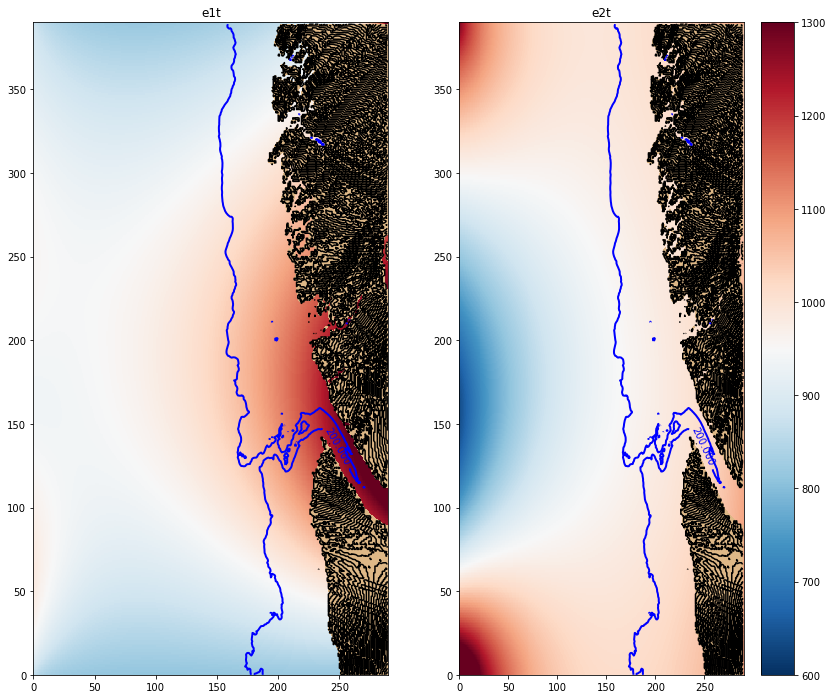

In [27]:
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter_high_res_cubic_truncated_flatten_2000m.nc'
bathymetry = nc.Dataset(bathy).variables['Bathymetry'][:]

y_slice = np.arange(0, 390)
x_slice = np.arange(0, 290)

ax = [0, 0]
# date_NW = parse('2016 May 7 12:00')
# date_SE = parse('2016 Oct 15 12:00')

fig = plt.figure(figsize=(14,12))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.1)

# ax[3] = plt.subplot(gs[0:, 1])
ax[1] = plt.subplot(gs[0:, 1])
# ax[2] = plt.subplot(gs[1:, 1])
ax[0] = plt.subplot(gs[0:, 0])
# viz_tools.set_aspect(ax1)
# mesh = ax1.pcolormesh(T_grid_lon, T_grid_lat, e1t[0,...], cmap =cm.dense, vmin = 800, vmax = 1000)
mesh = ax[0].pcolormesh(e1t[0,...], vmin=600, vmax = 1300, cmap='RdBu_r')
viz_tools.plot_land_mask(ax[0], bathy , xslice=np.arange(T_grid_lat.shape[1]), yslice=np.arange(T_grid_lat.shape[0]), color='burlywood')
viz_tools.plot_coastline(ax[0], bathy)

mesh2 = ax[1].pcolormesh(e2t[0,...], vmin=600, vmax = 1300, cmap='RdBu_r')
viz_tools.plot_land_mask(ax[1], bathy , xslice=np.arange(T_grid_lat.shape[1]), yslice=np.arange(T_grid_lat.shape[0]), color='burlywood')
viz_tools.plot_coastline(ax[1], bathy)

ax[0].set_title("e1t")
ax[1].set_title("e2t")
cbar = fig.colorbar(mesh2, ax=ax[1])
CS = ax[0].contour(x_slice,y_slice,bathymetry, levels = [200], colors=('blue',),linestyles=('-',),linewidths=(2,),label = "200m Isoabth")
CS2 = ax[1].contour(x_slice,y_slice,bathymetry, levels = [200], colors=('blue',),linestyles=('-',),linewidths=(2,),label = "200m Isoabth")

plt.clabel(CS)
plt.clabel(CS2)

### This shows that around the CANYONS we have achieved the 1Km resolution

In [18]:
#project the NEMO co-ordinates to cascadia coordinates

x,y,z,p = getcascadia(cascadiafile)

In [19]:
Xt, Yt = p(T_grid_lon, T_grid_lat)

In [20]:
X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')

X,Y,z = X.flatten(), Y.flatten(), z.flatten()

In [21]:
whos

Variable       Type        Data/Info
------------------------------------
Axes3D         type        <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
Dataset        type        <class 'netCDF4._netCDF4.Dataset'>
Proj           type        <class 'pyproj.Proj'>
T_grid_lat     ndarray     390x290: 113100 elems, type `float64`, 904800 bytes (883.59375 kb)
T_grid_lon     ndarray     390x290: 113100 elems, type `float64`, 904800 bytes (883.59375 kb)
X              ndarray     38294685: 38294685 elems, type `float64`, 306357480 bytes (292.1652603149414 Mb)
Xt             ndarray     390x290: 113100 elems, type `float64`, 904800 bytes (883.59375 kb)
Y              ndarray     38294685: 38294685 elems, type `float64`, 306357480 bytes (292.1652603149414 Mb)
Yt             ndarray     390x290: 113100 elems, type `float64`, 904800 bytes (883.59375 kb)
ax             list        n=2
bathy          str         /ocean/ssahu/CANYONS/wcvi<...>y_meter_high_res_cubic.nc
binstobathy    function    <function 

In [ ]:
# Construct new bathy using interpolation
points = (X,Y)
xi = (Xt.flatten(), Yt.flatten())
casnearest = np.reshape(interpolate.griddata(points, z, xi, method='cubic'), Xt.shape)

In [ ]:
# subroutine copied from Michael's bathy_helpers.py

def lakefill(bathy):
    # Reimplementation of JP's fill_in_lakes.m
    # The strategy is to diffuse a tracer from the open boundary
    # through the whole domain in 2D. Any non-land points that the tracer
    # doesn't reach are lakes and we fill them.
    idxland = bathy == 0           # Record initial land points
    ocean = np.zeros(bathy.shape)   
#    ocean[0,:] = 1                 # Put tracer on southern boundary, except for (Salish Sea)
    ocean[:,0] =1                   # Put tracer on western bloundary, except for (in WCVI)
    ocean[idxland]=0               # land points, meaning southern open bdy

    flag, it = True, 0
    stencil = np.array([[0,1,0],[1,0,1],[0,1,0]])  # diffusion schedule
    while flag:
        nocean = np.sum(ocean)
        it += 1
        ocean = signal.convolve2d(ocean, stencil, mode='same')  # Diffusion step
        ocean[idxland]=0   # Reset land to zero
        ocean[ocean>0]=1   # Anywhere that has tracer is now wet
        flag = np.sum(ocean) > nocean
    
    idxwater = ocean == 1  # Define ocean as connected wet points
    idxlakes = (~idxwater) & (~idxland)  # Lakes are not ocean and not land

    bathyout = np.copy(bathy)
    bathyout[idxlakes] = 0     # Fill the lakes

    print ("Lakes filled in {} iterations".format(it))
    return bathyout

In [ ]:
casnearest = lakefill(casnearest)

In [21]:
def writebathy(filename,glamt,gphit,bathy):

    bnc = nc.Dataset(filename, 'w', clobber=True)
    NY,NX = glamt.shape

    # Create the dimensions
    bnc.createDimension('x', NX)
    bnc.createDimension('y', NY)

    bnc.createVariable('nav_lon', 'f', ('y', 'x'), zlib=True, complevel=4)
    bnc.variables['nav_lon'].setncattr('units', 'degrees_east')

    bnc.createVariable('nav_lat', 'f', ('y', 'x'), zlib=True, complevel=4)
    bnc.variables['nav_lat'].setncattr('units', 'degrees_north')

    bnc.createVariable('Bathymetry', 'd', ('y', 'x'), zlib=True, complevel=4, fill_value=0)
    bnc.variables['Bathymetry'].setncattr('units', 'metres')

    bnc.variables['nav_lon'][:] = glamt
    bnc.variables['nav_lat'][:] = gphit
    bnc.variables['Bathymetry'][:] = bathy

    bnc.close()

In [ ]:
writebathy('bathy_meter_high_res_cubic_truncated.nc',T_grid_lon,T_grid_lat,casnearest)

In [ ]:
# #Write Bathymetry to NetCDF file
# writebathy('bathy_meter_high_res.nc',T_grid_lon,T_grid_lat,casnearest)

In [3]:
bathy_data = nc.Dataset('bathy_meter_high_res_cubic_truncated.nc')
nc_tools.show_variables(bathy_data)
nc_tools.show_dimensions(bathy_data)

odict_keys(['nav_lon', 'nav_lat', 'Bathymetry'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 290

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 390



In [16]:
X = bathy_data.variables['nav_lon']
Y = bathy_data.variables['nav_lat']
Z = np.array(bathy_data.variables['Bathymetry'])

In [18]:
for i in np.arange(Z.shape[0]):
    for j in np.arange(Z.shape[1]):
        if Z[i,j]>=2000:
            Z[i,j] = 2000
        else:
            continue
            


In [19]:
np.max(Z)

2000.0

#### This was before making the bathymetry below 2000 = 2000

<IPython.core.display.Javascript object>


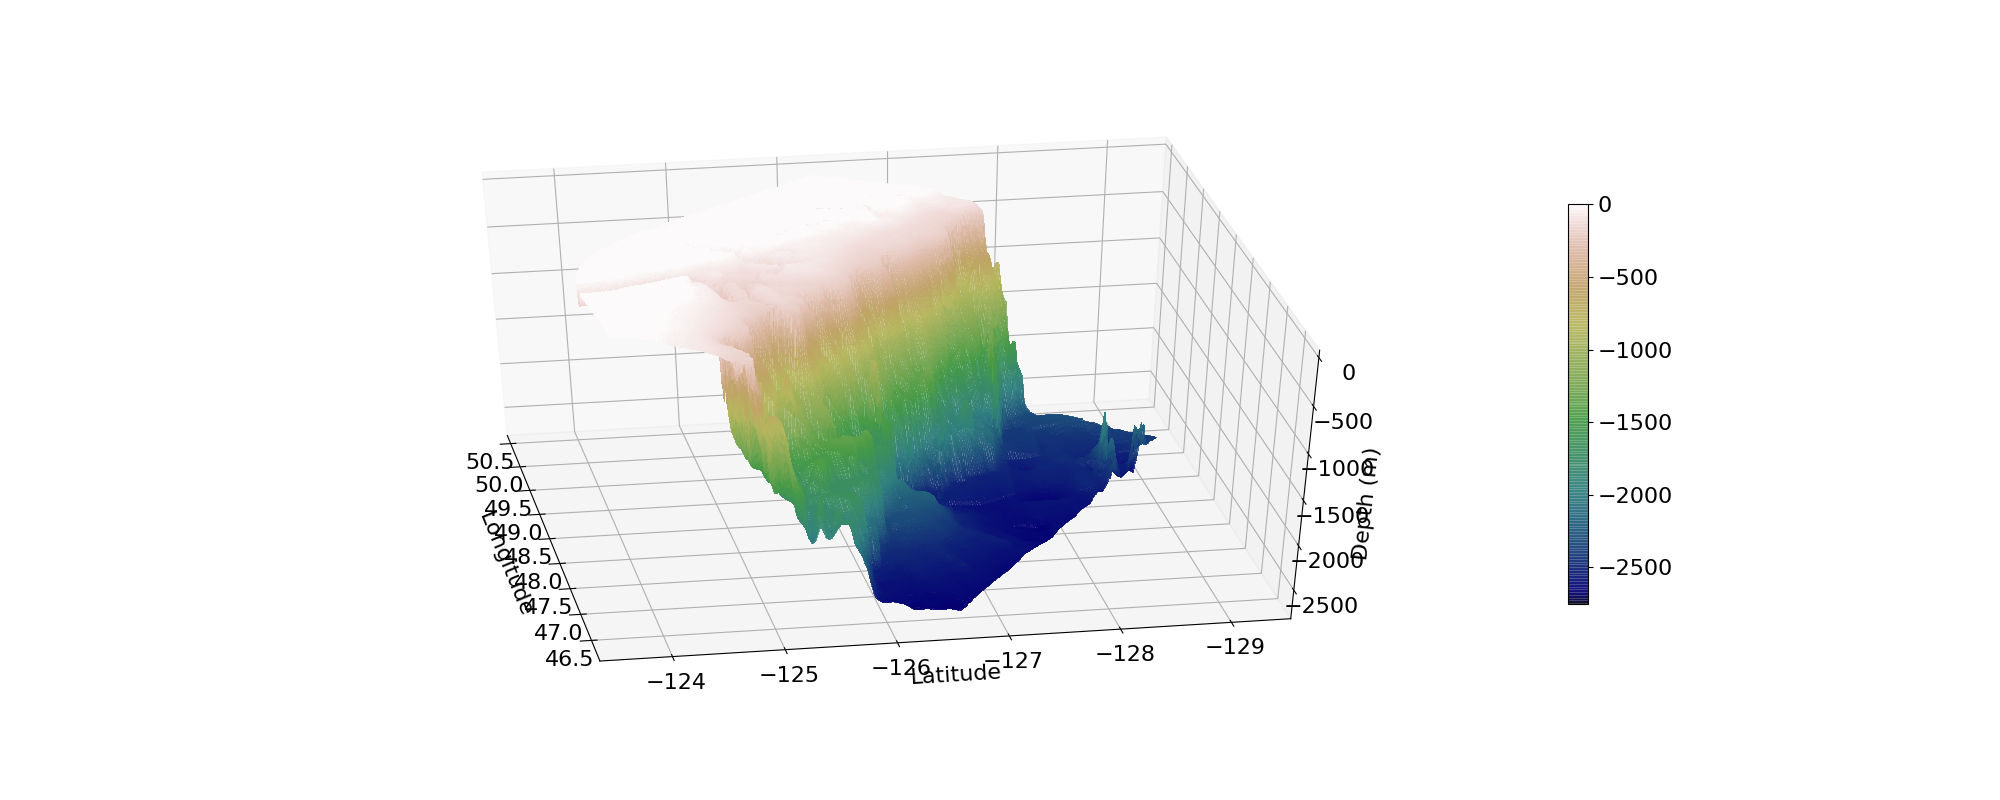

In [5]:
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


plt.rcParams['contour.negative_linestyle'] = 'solid' # default is to have negative contours with dashed lines
plt.rcParams.update({'font.size':16})

# Plot 3D bathymetry

fig = plt.figure(figsize=(20,8))


# xvec = np.arange(Z.shape[0])
# yvec= np.arange(Z.shape[1])

# X,Y = np.meshgrid(yvec,xvec,indexing = 'xy')


# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

p = ax.plot_surface(Y,X,np.multiply(-1,Z), rstride=1, cstride=1,alpha=0.75,cmap=cm.gist_earth, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.65)
# cset = ax.contour(Y,X,Z, colors='k',linewidth=2, rstride=2, cstride=2,zdir='z')

ax.set_aspect('auto')

ax.view_init(40, 350+180) # elevation and azimuth

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Depth (m)')

plt.show()

#### When we flatten out the part less than 2000m 

<IPython.core.display.Javascript object>


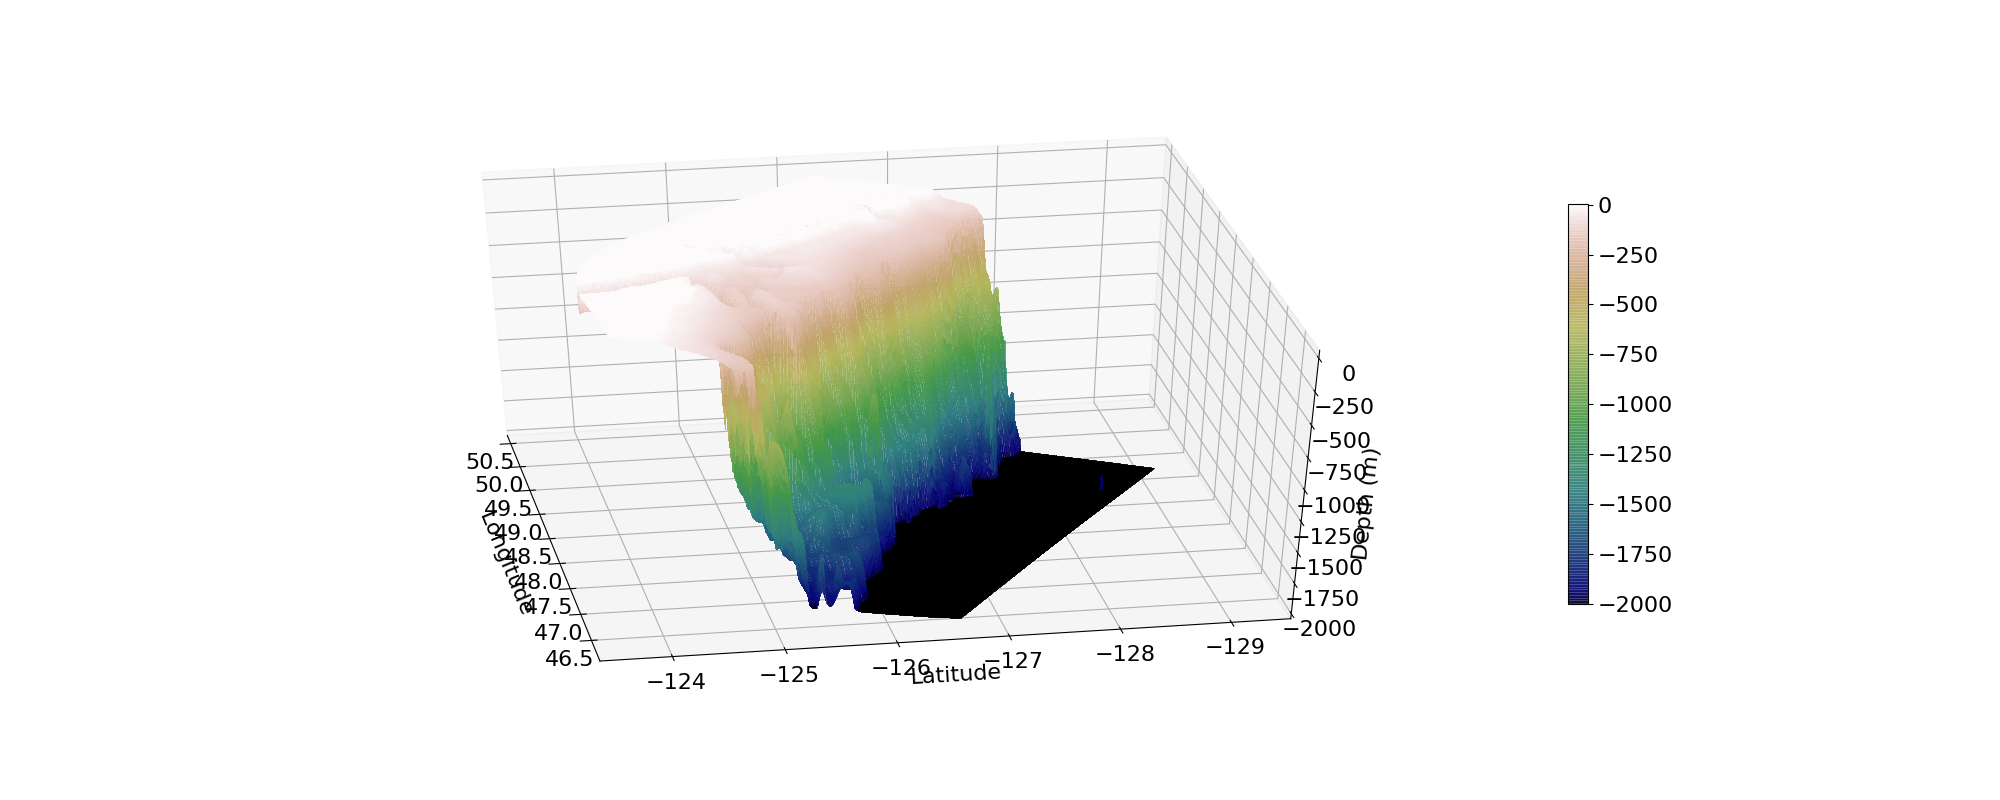

In [20]:
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

plt.rcParams['contour.negative_linestyle'] = 'solid' # default is to have negative contours with dashed lines
plt.rcParams.update({'font.size':16})

# Plot 3D bathymetry

fig = plt.figure(figsize=(20,8))


# xvec = np.arange(Z.shape[0])
# yvec= np.arange(Z.shape[1])

# X,Y = np.meshgrid(yvec,xvec,indexing = 'xy')


# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

p = ax.plot_surface(Y,X,np.multiply(-1,Z), rstride=1, cstride=1,alpha=0.75,cmap=cm.gist_earth, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.65)
# cset = ax.contour(Y,X,Z, colors='k',linewidth=2, rstride=2, cstride=2,zdir='z')

ax.set_aspect('auto')

ax.view_init(40, 350+180) # elevation and azimuth

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Depth (m)')

plt.show()

In [26]:
writebathy('bathy_meter_high_res_cubic_truncated_flatten_2000m.nc',T_grid_lon,T_grid_lat,Z)

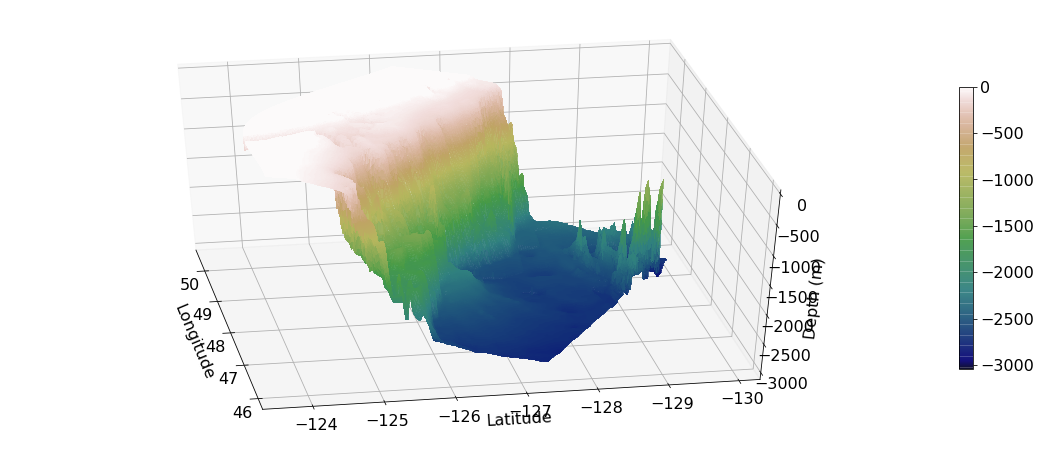

In [145]:
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

plt.rcParams['contour.negative_linestyle'] = 'solid' # default is to have negative contours with dashed lines
plt.rcParams.update({'font.size':16})

# Plot 3D bathymetry

fig = plt.figure(figsize=(20,8))


# xvec = np.arange(Z.shape[0])
# yvec= np.arange(Z.shape[1])

# X,Y = np.meshgrid(yvec,xvec,indexing = 'xy')


# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

p = ax.plot_surface(Y,X,np.multiply(-1,Z), rstride=1, cstride=1,alpha=0.75,cmap=cm.gist_earth, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.65)
# cset = ax.contour(Y,X,Z, colors='k',linewidth=2, rstride=2, cstride=2,zdir='z')

ax.set_aspect('auto')

ax.view_init(40, 350+180) # elevation and azimuth

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Depth (m)')

plt.show()

In [113]:
Z.shape

(300, 390)

AttributeError: module 'cmocean.cm' has no attribute 'gist_earth'

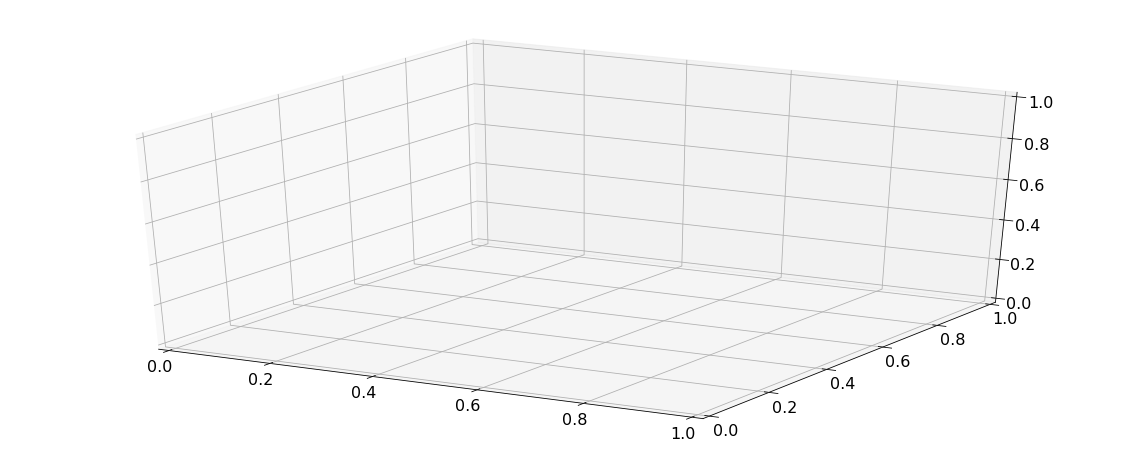

In [119]:
ysize = 390 # number of grid points in x and y directions
xsize = 300

xwall = 450000.0 # Same as in GenerateCanyonBathy.ipynb. Length of the domain along x (m)
ywall = 300000.0  # Same as in GenerateCanyonBathy.ipynb. Length of the domain along y (m)



xvec = np.arange(0,xsize)
yvec = np.arange(0,ysize)

X_p,Y_p = np.meshgrid(yvec,xvec,indexing='xy')

plt.rcParams['contour.negative_linestyle'] = 'solid' # default is to have negative contours with dashed lines
plt.rcParams.update({'font.size':16})

# Plot 3D bathymetry

fig = plt.figure(figsize=(20,8))

# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

p = ax.plot_surface(X_p,Y_p,Z, rstride=2, cstride=2,alpha=0.75,cmap=cm.gist_earth, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.65)
#cset = ax.contour(X_p,Y_p,Z,colors='k',linewidth=2, rstride=2, cstride=2,zdir='z')

ax.set_aspect('auto')

ax.view_init(35, 100) # elevation and azimuth

ax.set_ylabel('Y (m)')
ax.set_xlabel('X (m)')
ax.set_zlabel('Depth (m)')

<IPython.core.display.Javascript object>


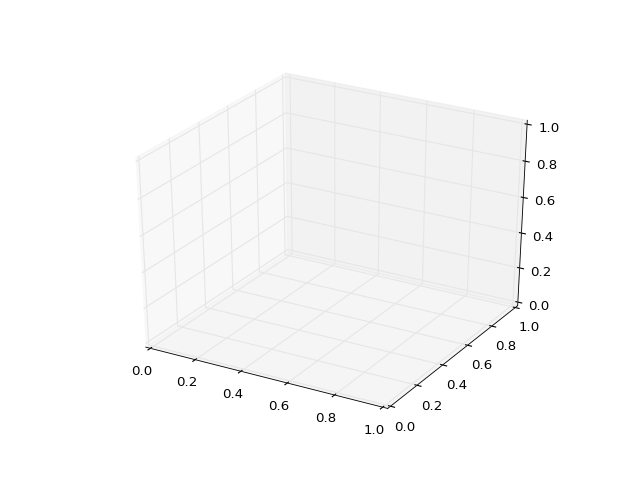

AttributeError: module 'cmocean.cm' has no attribute 'coolwarm'

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#Axes3D.plot_surface(X, Y, Z)
surf = ax.plot_surface(X,Y,np.multiply(-1,Z), cmap=cm.coolwarm, cstride=1, rstride=1, linewidth=0)
cbmin = -1300; cbmax = 0
surf.set_clim([cbmin,cbmax]); cb.set_clim(cbmin,cbmax)
cb=plt.colorbar(surf)


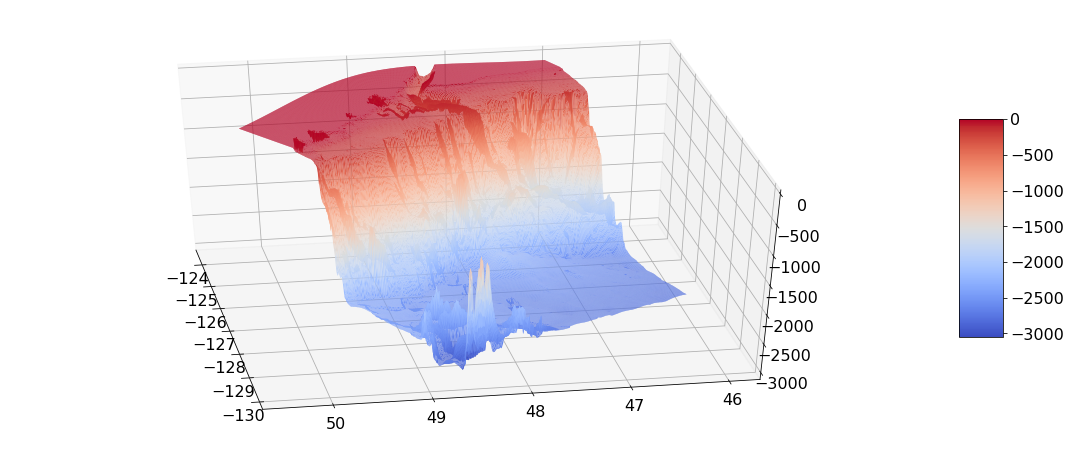

In [147]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, np.multiply(-1,Z), cmap=cm.coolwarm, cstride=1, rstride=1, linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(40, 350+180) # elevation and azimuth

plt.show()

<IPython.core.display.Javascript object>


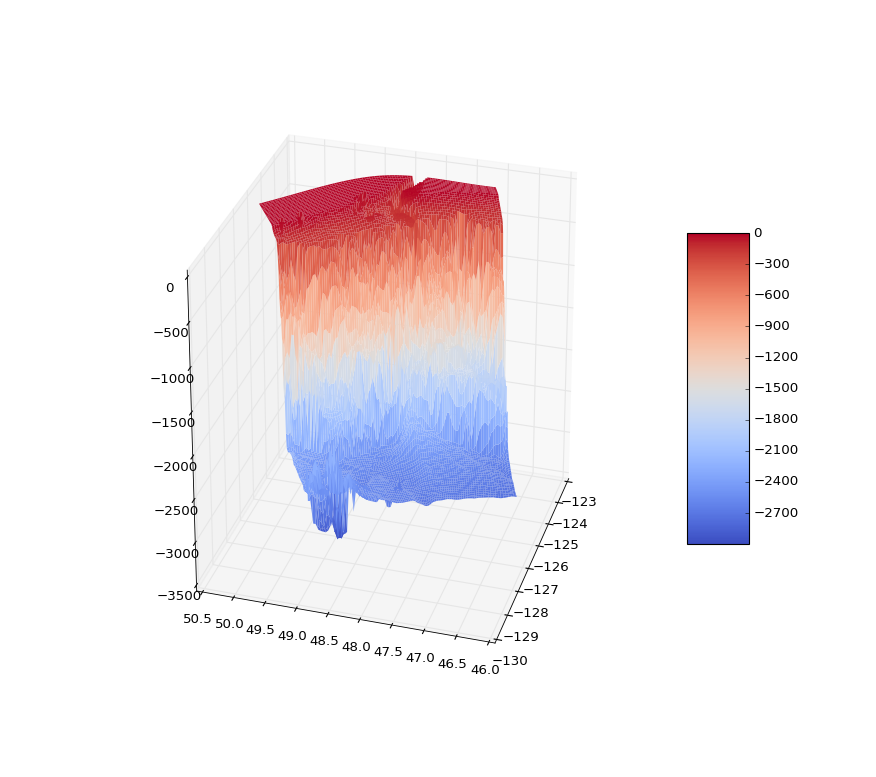

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, np.multiply(-1,Z), cmap=cm.coolwarm, cstride=1, rstride=1, linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

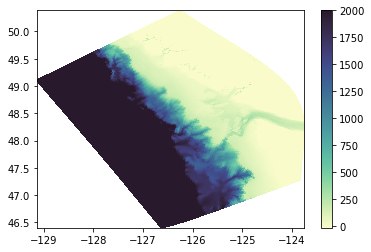

In [28]:
plt.figure()
import cmocean.cm as cm

cmap = plt.get_cmap(cm.deep)
cmap.set_bad('burlywood')
plt.pcolormesh(X, Y, Z, cmap=cmap)
plt.colorbar()

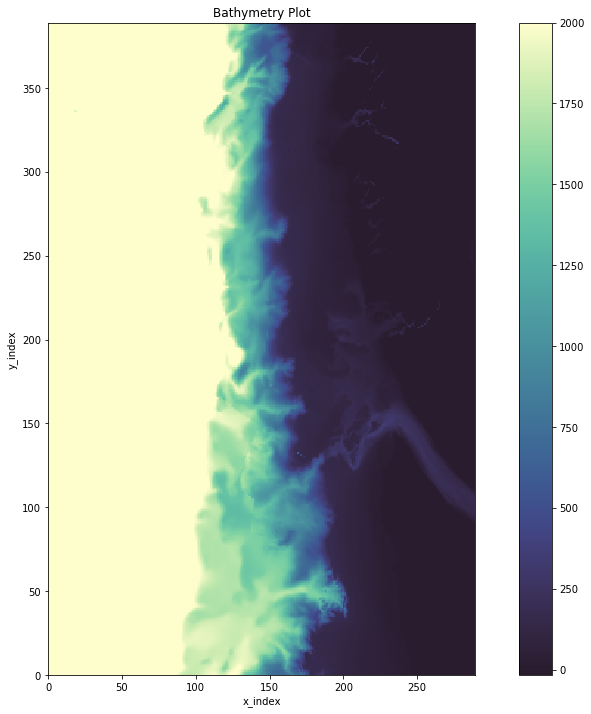

In [60]:
fig, axr = plt.subplots(1, 1, figsize=(16,12))
land_colour = 'burlywood'


viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
# mesh = axr.pcolormesh(X,Y,Z, cmap=cmap)
mesh = axr.pcolormesh(x_slice,y_slice,Z, cmap=cmap)
# legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x_index')
axr.set_ylabel('y_index')
cbar = plt.colorbar(mesh)
# axr.grid()

In [39]:
bathymetry.shape

(390, 290)

In [40]:
Z.shape

(390, 290)